## Practical 8bis: Working with Text (Part 2)

The basics of Text Mining and NLP

Part 2 of Practical 8 is *optional* and should only be attempted if Part
1 made sense to you.

1.  The first few tasks are about finding important vocabulary (think
    ‘keywords’ and ‘significant terms’) in documents so that you can
    start to think about what is *distinctive* about documents and
    groups of documents. **This is quite useful and relatively easier to
    understand than what comes next!**
2.  The second part is about fully-fledged NLP using Latent Direclecht
    Allocation (topic modelling) and Word2Vec (words embeddings for use
    in clustering or similarity work).

The later parts are largely complete and ready to run; however, that
*doesn’t* mean you should just skip over them and think you’ve grasped
what’s happening and it will be easy to apply in your own analyses. I
would *not* pay as much attention to LDA topic mining since I don’t
think it’s results are that good, but I’ve included it here as it’s
still commonly-used in the Digital Humanities and by Marketing folks.
Word2Vec is much more powerful and forms the basis of the kinds of
advances seen in ChatGPT and other LLMs.

> **🔗 Connections**
>
> Working with text is unquestionably *hard*. In fact, *conceptually*
> this is probaly the most challenging practical of the term! But data
> scientists are *always* dealing with text because so much of the data
> that we collect (even more so thanks to the web) is not only
> text-based (URLs are text!) but, increasingly, unstructured (social
> media posts, tags, etc.). So while getting to grips with text is a
> challenge, it also uniquely positions you with respect to the skills
> and knowledge that other graduates are offering to employers.

## 1. Preamble

This practical has been written using `nltk`, but would be *relatively*
easy to rework using `spacy`. Most programmers tend to use one *or* the
other, and the switch wouldn’t be hard other than having to first load
the requisite language models:

In [1]:
import spacy

# `...web_md` and `...web_lg` are also options
corp = "en_core_web_sm"

try: 
    nlp = spacy.load(corp)
except OSError:
    spacy.cli.download(corp)
    nlp = spacy.load(corp)

You can [read about the models](https://spacy.io/models/en), and note
that they are also [available in other
languages](https://spacy.io/usage/models) besides English.

## 2. Setup

> **Difficulty Level: Low**
>
> But this is only because this has been worked out for you. Starting
> from sctach in NLP is *hard* so people try to avoid it as much as
> possible.

### 2.1 Required Modules

> **Note**
>
> Notice that the number of modules and functions that we import is
> steadily increasing week-on-week, and that for text processing we tend
> to draw on quite a wide range of utilies! That said, the three most
> commonly used are: `sklearn`, `nltk`, and `spacy`.

Standard libraries we’ve seen before.

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import re
import math
import matplotlib.pyplot as plt

Vectorisers we will use from the ‘big beast’ of Python machine learning:
Sci-Kit Learn.

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# We don't use this but I point out where you *could*
from sklearn.preprocessing import OneHotEncoder 

NLP-specific libraries that we will use for tokenisation, lemmatisation,
and frequency analysis.

In [4]:
import nltk
import spacy
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

try:
    from nltk.corpus import stopwords
except:
    nltk.download('stopwords')
    from nltk.corpus import stopwords
stopword_list = set(stopwords.words('english'))

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from nltk import ngrams, FreqDist

lemmatizer = WordNetLemmatizer()
tokenizer = ToktokTokenizer()

Remaining libraries that we’ll use for processing and display text data.
Most of this relates to dealing with the various ways that text data
cleaning is *hard* because of the myriad formats it comes in.

In [5]:
import string
import unicodedata
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS

This next is just a small utility function that allows us to output
Markdown (like this cell) instead of plain text:

In [6]:
from IPython.display import display_markdown

def as_markdown(head='', body='Some body text'):
    if head != '':
        display_markdown(f"##### {head}\n\n>{body}\n", raw=True)
    else:
        display_markdown(f">{body}\n", raw=True)

as_markdown('Result!', "Here's my output...")

### 2.2 Loading Data

> **🔗 Connections**
>
> Because I generally want each practical to stand on its own (unless
> I’m trying to make a *point*), I’ve not moved this to a separate
> Python file (e.g. `utils.py`, but in line with what we covered back in
> the lectures on [Functions and
> Packages](https://jreades.github.io/fsds/sessions/week3.html#lectures),
> this sort of thing is a good candidate for being split out to a
> separate file to simplify re-use.

Remember this function from last week? We use it to save downloading
files that we already have stored locally. But notice I’ve made some
small changes… what do these do to help the user?

In [7]:
import os
from requests import get
from urllib.parse import urlparse
from functools import wraps

def check_cache(f):
    @wraps(f)
    def wrapper(src, dst, min_size=100):
        url = urlparse(src) # We assume that this is some kind of valid URL 
        fn  = os.path.split(url.path)[-1] # Extract the filename
        dsn = os.path.join(dst,fn) # Destination filename
        if os.path.isfile(dsn) and os.path.getsize(dsn) > min_size:
            print(f"+ {dsn} found locally!")
            return(dsn)
        else:
            print(f"+ {dsn} not found, downloading!")
            return(f(src, dsn))
    return wrapper

@check_cache
def cache_data(src:str, dst:str) -> str:
    """Downloads a remote file.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dst : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """

    # Convert the path back into a list (without)
    # the filename -- we need to check that directories
    # exist first.
    path = os.path.split(dst)[0]
    print(f"Path: {path}")
      
    # Create any missing directories in dest(ination) path
    # -- os.path.join is the reverse of split (as you saw above)
    # but it doesn't work with lists... so I had to google how
    # to use the 'splat' operator! os.makedirs creates missing
    # directories in a path automatically.
    if path != '':
        os.makedirs(path, exist_ok=True)
        
    # Download and write the file
    with open(dst, "wb") as file:
        response = get(src)
        file.write(response.content)
        
    print(' + Done downloading...')

    return dst

> **Tip**
>
> For very large *non*-geographic data sets, remember that you can
> `use_cols` (or `columns` depending on the file type) to specify a
> subset of columns to load.

Load the main data set:

In [8]:
# Load the data sets created in the previous practical
lux    = gpd.read_parquet(os.path.join('data','clean','luxury.geopackage'))
aff    = gpd.read_parquet(os.path.join('data','clean','affordable.geopackage'))
bluesp = gpd.read_parquet(os.path.join('data','clean','bluespace.geopackage'))

## 3. Illustrative Text Cleaning

Now we’re going to step through the *parts* of the process that we apply
to clean and transform text. We’ll do this individually before using a
function to apply them *all at once*.

### 3.1 Downloading a Web Page

> **Difficulty Level: Low.**

There is plenty of good economic geography research being done using web
pages. Try using Google Scholar to look for work using the British
Library’s copy of the *Internet Archive*.

In [9]:
from urllib.request import urlopen, Request

# We need this so that the Bartlett web site 'knows'
# what kind of browser it is deasling with. Otherwise
# you get a Permission Error (403 Forbidden) because
# the site doesn't know what to do.
hdrs = {
    'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
}
url = 'https://www.ucl.ac.uk/bartlett/casa/about-0'

##### Question

``` python
# Notice that here we have to assemble a request and
# then 'open' it so that the request is properly issued
# to the web server. Normally, we'd just use `urlopen`, 
# but that doesn't give you the ability to set the headers.
request  = Request(url, None, hdrs) #The assembled request
response = urlopen(request)
html     = response.???.decode('utf-8') # The data you need

print(html[:1000])
```

##### Answer

``` python
# Notice that here we have to assemble a request and
# then 'open' it so that the request is properly issued
# to the web server. Normally, we'd just use `urlopen`, 
# but that doesn't give you the ability to set the headers.
request  = Request(url, None, hdrs) #The assembled request
response = urlopen(request)
html     = response.read().decode('utf-8') # The data you need

print(html[:1000])
```

    <!DOCTYPE html>
    <!--[if IE 7]>
    <html lang="en" class="lt-ie9 lt-ie8 no-js"> <![endif]-->
    <!--[if IE 8]>
    <html lang="en" class="lt-ie9 no-js"> <![endif]-->
    <!--[if gt IE 8]><!-->
    <html lang="en" class="no-js"> <!--<![endif]-->
    <head>
      <meta name="viewport" content="width=device-width, initial-scale=1.0"/>
      <meta name="author" content="UCL"/>
      <meta property="og:profile_id" content="uclofficial"/>
      <meta http-equiv="Content-Type" content="text/html; charset=utf-8" />
    <link rel="shortcut icon" href="https://www.ucl.ac.uk/bartlett/casa/sites/all/themes/indigo/favicon.ico" type="image/vnd.microsoft.icon" />
    <meta name="description" content="The Centre for Advanced Spatial Analysis (CASA) is an interdisciplinary research institute focusing on the science of cities within The Bartlett Faculty of the Built Environment at UCL." />
    <link rel="canonical" href="https://www.ucl.ac.uk/bartlett/casa/about-0" />
    <meta name="ucl:faculty" content="Bartlett" />
    <meta name="ucl:org_unit" content="Cent

### 3.2 Removing HTML

> **Difficulty level: Moderate**
>
> Because what we’re doing will seem really strange and uses some
> previously unseen libraries that you’ll have to google.

*Hint*: you need to need to **get the text** out of the each returned
`<p>` and `<div>` element! I’d suggest also commenting this up since
there is a *lot* going on on some of these lines of code!

##### Question

``` python
cleaned = []

soup = BeautifulSoup(html)
body = soup.find('body')

for c in body.findChildren(recursive=False):
    if c.name in ['div','p'] and c.???.strip() != '': 
        # \xa0 is a non-breaking space in Unicode (&nbsp; in HTML)
        txt = [re.sub(r'(?:\u202f|\xa0|\u200b)',' ',x.strip()) for x in c.get_text(separator=" ").split('\n') if x.strip() != '']
        cleaned += txt

cleaned
```

##### Answer

``` python
cleaned = []

soup = BeautifulSoup(html)
body = soup.find('body')

for c in body.findChildren(recursive=False):
    if c.name in ['div','p'] and c.get_text().strip() != '':
        # \xa0 is a non-breaking space in Unicode (&nbsp; in HTML)
        txt = [re.sub(r'(?:\u202f|\xa0|\u200b)',' ',x.strip()) for x in c.get_text(separator=" ").split('\n') if x.strip() != '']
        cleaned += txt

cleaned
```

    ['UCL Home The Bartlett Centre for Advanced Spatial Analysis About',
     'About',
     'The Centre for Advanced Spatial Analysis (CASA) is an interdisciplinary research institute focusing on the science of cities within The Bartlett Faculty of the Built Environment at UCL.',
     'The Centre for Advanced Spatial Analysis (CASA) was established in 1995 to lead the development of a science of cities drawing upon methods and ideas in modelling and data science, sensing the urban environment, visualisation and computation.  Today, CASA’s research is still pushing boundaries to create better cities for everyone, both leading the intellectual agenda and working closely with government and industry partners to make real-world impact.  Our teaching reflects this, making the most of our cutting-edge research, tools, new forms of data, and long-standing non-academic partnerships to train the next generation of urban scientists with the skills and ideas they’ll need to have an impact in industry, government, academia, and the third sector.  The CASA community is closely connected, but strongly interdisciplinary. We bring together people from around the world with a unique variety of backgrounds – including physicists, planners, geographers, economists, data scientists, architects, mathematicians and computer scientists – united by our mission to tackle the biggest challenges facing cities and societies around the world.  We work across multiple scales: from the hyper-local environment of the low-powered sensor all the way up to satellite remote sensing of whole countries and regions.  Studying at CASA brings lifelong value, with our students poised to take on leadership and integration roles at the forefront of urban and spatial data science.  By studying with us you will become part of our active and engaged alumni community, with access to job listings, networking and social activities, as well as continued contact with our outstanding teachers and researchers.   Location The UCL Centre for Advanced Spatial Analysis is located at 90 Tottenham Court Road, London, W1T 4TJ.',
     'View Map',
     'Contact Address: UCL Centre for Advanced Spatial Analysis First Floor, 90 Tottenham Court Road London W1T 4TJ Telephone:  +44 (0)20 3108 3877 Email:   casa@ucl.ac.uk']

### 3.3 Lower Case

> **Difficulty Level: Low.**

##### Question

``` python
lower = [c.???() for ??? in cleaned]
lower
```

##### Answer

``` python
lower = [s.lower() for s in cleaned]
lower
```

    ['ucl home the bartlett centre for advanced spatial analysis about',
     'about',
     'the centre for advanced spatial analysis (casa) is an interdisciplinary research institute focusing on the science of cities within the bartlett faculty of the built environment at ucl.',
     'the centre for advanced spatial analysis (casa) was established in 1995 to lead the development of a science of cities drawing upon methods and ideas in modelling and data science, sensing the urban environment, visualisation and computation.  today, casa’s research is still pushing boundaries to create better cities for everyone, both leading the intellectual agenda and working closely with government and industry partners to make real-world impact.  our teaching reflects this, making the most of our cutting-edge research, tools, new forms of data, and long-standing non-academic partnerships to train the next generation of urban scientists with the skills and ideas they’ll need to have an impact in industry, government, academia, and the third sector.  the casa community is closely connected, but strongly interdisciplinary. we bring together people from around the world with a unique variety of backgrounds – including physicists, planners, geographers, economists, data scientists, architects, mathematicians and computer scientists – united by our mission to tackle the biggest challenges facing cities and societies around the world.  we work across multiple scales: from the hyper-local environment of the low-powered sensor all the way up to satellite remote sensing of whole countries and regions.  studying at casa brings lifelong value, with our students poised to take on leadership and integration roles at the forefront of urban and spatial data science.  by studying with us you will become part of our active and engaged alumni community, with access to job listings, networking and social activities, as well as continued contact with our outstanding teachers and researchers.   location the ucl centre for advanced spatial analysis is located at 90 tottenham court road, london, w1t 4tj.',
     'view map',
     'contact address: ucl centre for advanced spatial analysis first floor, 90 tottenham court road london w1t 4tj telephone:  +44 (0)20 3108 3877 email:   casa@ucl.ac.uk']

### 3.4 Stripping ‘Punctuation’

> **Difficulty level: Hard**
>
> This is because you need to understand: 1) why we’re *compiling* the
> regular expression and how to use character classes; and 2) how the
> NLTK tokenizer differs in approach to the regex.

#### 3.4.1 Regular Expression Approach

We want to clear out punctuation using a regex that takes advantage of
the `[...]` (character class) syntax. The really tricky part is
remembering how to specify the ‘punctuation’ when some of that
punctuation has ‘special’ meanings in a regular expression context. For
instance, `.` means ‘any character’, while `[` and `]` mean ‘character
class’. So this is another *escaping* problem and it works the *same*
way it did when we were dealing with the Terminal…

*Hints*: some other factors…

1.  You will want to match more than one piece of punctuation at a time,
    so I’d suggest add a `+` to your pattern.
2.  You will need to look into *metacharacters* for creating a kind of
    ‘any of the characters *in this class*’ bag of possible matches.

##### Question

``` python
pattern = re.compile(r'[???]+')
print(pattern)
```

##### Answer

``` python
pattern = re.compile(r'[,\.!\-><=\(\)\[\]\/&\'\"’;\+\–\—]+')
print(pattern)
```

    re.compile('[,\\.!\\-><=\\(\\)\\[\\]\\/&\\\'\\"’;\\+\\–\\—]+')

#### 3.4.2 Tokenizer

The other way to do this, which is probably *easier* but produces more
complex output, is to draw on the tokenizers [already provided by
NLTK](https://www.nltk.org/api/nltk.tokenize.html). For our purposes
`word_tokenize` is probably fine, but depending on your needs there are
other options and you can also write your own.

In [14]:
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
print(word_tokenize)

<function word_tokenize at 0x169b3e160>

[nltk_data] Downloading package punkt to /Users/jreades/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jreades/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!

#### 3.4.3 Compare

Look at how these outputs differ in subtle ways:

In [15]:
subbed = []
tokens = []
for l in lower:
    subbed.append(re.sub(pattern, ' ', l))
    tokens.append(word_tokenize(l))

for s in subbed:
    as_markdown("Substituted", s)

for t in tokens:
    as_markdown("Tokenised", t)

### 3.5 Stopword Removal

> **Difficulty Level: Moderate**
>
> You need to remember how list comprehensions work to use the
> `stopword_list`.

In [16]:
stopword_list = set(stopwords.words('english'))
print(stopword_list)

{'am', 'an', 'i', 'by', 'yours', 'him', 'won', 'she', 'couldn', 'both', "weren't", 'or', "she's", 'for', 'other', 'aren', 'are', "hadn't", 'there', 'itself', "you've", 'further', 're', 'your', 'over', 'some', 'should', 'herself', "couldn't", 'before', 'do', 't', 'has', 'so', 'themselves', 'who', 'too', 'now', 'we', 'd', 'each', 'shan', 'through', "that'll", 'will', 'hasn', 'what', 'having', 'then', 'he', 'out', 'why', 'shouldn', 'hers', 'these', 'just', "don't", 'hadn', 'ma', 'same', 'if', 'me', 'at', "mightn't", 'not', 'those', 'was', "wasn't", 'that', 'have', 'about', "you're", 'were', 'haven', 'on', 'below', 'in', 'only', 'to', 'mustn', "doesn't", 'wasn', "aren't", 'very', 'our', 'between', 'is', 'above', 'nor', 'its', "you'd", 'been', "hasn't", 'into', "you'll", "haven't", 'because', 'them', 'most', 'don', "mustn't", 'here', 'such', 'doesn', 'their', 'how', 'll', 'mightn', 'down', "should've", 'after', 'a', 'with', 'of', 've', 'while', 'whom', 'did', 'when', "shan't", 'against', 'i

##### Question

``` python
stopped = []
for p in tokens[2:4]: # <-- why do I just take these items from the list?
    stopped.append([x for x in p if x not in ??? and len(x) > 1])

for s in stopped:
    as_markdown("Line", s)
```

##### Answer

``` python
stopped = []
for p in tokens[2:4]: # <-- why do I just take these items from the list?
    stopped.append([x for x in p if x not in stopword_list and len(x) > 1])

for s in stopped:
    as_markdown("Line", s)
```

###### 3.5.0.0.1 Line

> \[‘centre’, ‘advanced’, ‘spatial’, ‘analysis’, ‘casa’,
> ‘interdisciplinary’, ‘research’, ‘institute’, ‘focusing’, ‘science’,
> ‘cities’, ‘within’, ‘bartlett’, ‘faculty’, ‘built’, ‘environment’,
> ‘ucl’\]

###### 3.5.0.0.2 Line

> \[‘centre’, ‘advanced’, ‘spatial’, ‘analysis’, ‘casa’, ‘established’,
> ‘1995’, ‘lead’, ‘development’, ‘science’, ‘cities’, ‘drawing’, ‘upon’,
> ‘methods’, ‘ideas’, ‘modelling’, ‘data’, ‘science’, ‘sensing’,
> ‘urban’, ‘environment’, ‘visualisation’, ‘computation’, ‘today’,
> ‘casa’, ‘research’, ‘still’, ‘pushing’, ‘boundaries’, ‘create’,
> ‘better’, ‘cities’, ‘everyone’, ‘leading’, ‘intellectual’, ‘agenda’,
> ‘working’, ‘closely’, ‘government’, ‘industry’, ‘partners’, ‘make’,
> ‘real-world’, ‘impact’, ‘teaching’, ‘reflects’, ‘making’,
> ‘cutting-edge’, ‘research’, ‘tools’, ‘new’, ‘forms’, ‘data’,
> ‘long-standing’, ‘non-academic’, ‘partnerships’, ‘train’, ‘next’,
> ‘generation’, ‘urban’, ‘scientists’, ‘skills’, ‘ideas’, ‘need’,
> ‘impact’, ‘industry’, ‘government’, ‘academia’, ‘third’, ‘sector’,
> ‘casa’, ‘community’, ‘closely’, ‘connected’, ‘strongly’,
> ‘interdisciplinary’, ‘bring’, ‘together’, ‘people’, ‘around’, ‘world’,
> ‘unique’, ‘variety’, ‘backgrounds’, ‘including’, ‘physicists’,
> ‘planners’, ‘geographers’, ‘economists’, ‘data’, ‘scientists’,
> ‘architects’, ‘mathematicians’, ‘computer’, ‘scientists’, ‘united’,
> ‘mission’, ‘tackle’, ‘biggest’, ‘challenges’, ‘facing’, ‘cities’,
> ‘societies’, ‘around’, ‘world’, ‘work’, ‘across’, ‘multiple’,
> ‘scales’, ‘hyper-local’, ‘environment’, ‘low-powered’, ‘sensor’,
> ‘way’, ‘satellite’, ‘remote’, ‘sensing’, ‘whole’, ‘countries’,
> ‘regions’, ‘studying’, ‘casa’, ‘brings’, ‘lifelong’, ‘value’,
> ‘students’, ‘poised’, ‘take’, ‘leadership’, ‘integration’, ‘roles’,
> ‘forefront’, ‘urban’, ‘spatial’, ‘data’, ‘science’, ‘studying’, ‘us’,
> ‘become’, ‘part’, ‘active’, ‘engaged’, ‘alumni’, ‘community’,
> ‘access’, ‘job’, ‘listings’, ‘networking’, ‘social’, ‘activities’,
> ‘well’, ‘continued’, ‘contact’, ‘outstanding’, ‘teachers’,
> ‘researchers’, ‘location’, ‘ucl’, ‘centre’, ‘advanced’, ‘spatial’,
> ‘analysis’, ‘located’, ‘90’, ‘tottenham’, ‘court’, ‘road’, ‘london’,
> ‘w1t’, ‘4tj’\]

### 3.6 Lemmatisation vs Stemming

> **Difficulty level: Low.**

In [18]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer 

In [19]:
lemmatizer = WordNetLemmatizer()
print(lemmatizer.lemmatize('monkeys'))
print(lemmatizer.lemmatize('cities'))
print(lemmatizer.lemmatize('complexity'))
print(lemmatizer.lemmatize('Reades'))

monkey
city
complexity
Reades

In [20]:
stemmer = PorterStemmer()
print(stemmer.stem('monkeys'))
print(stemmer.stem('cities'))
print(stemmer.stem('complexity'))
print(stemmer.stem('Reades'))

monkey
citi
complex
read

In [21]:
stemmer = SnowballStemmer(language='english')
print(stemmer.stem('monkeys'))
print(stemmer.stem('cities'))
print(stemmer.stem('complexity'))
print(stemmer.stem('Reades'))

monkey
citi
complex
read

In [22]:
lemmatizer = WordNetLemmatizer()
lemmas  = []
stemmed = []

# This would be better if we passed in a PoS (Part of Speech) tag as well,
# but processing text for parts of speech is *expensive* and for the purposes
# of this tutorial, not necessary.
for s in stopped:
    lemmas.append([lemmatizer.lemmatize(x) for x in s])

for s in stopped:
    stemmed.append([stemmer.stem(x) for x in s])

for l in lemmas:
    as_markdown('Lemmatised',l)

for s in stemmed:
    as_markdown('Stemmed',s)

In [23]:
# What are we doing here?
for ix, p in enumerate(stopped):
    stopped_set = set(stopped[ix])
    lemma_set   = set(lemmas[ix])
    print(sorted(stopped_set.symmetric_difference(lemma_set)))

['cities', 'city']
['activities', 'activity', 'alumni', 'alumnus', 'architect', 'architects', 'background', 'backgrounds', 'boundaries', 'boundary', 'challenge', 'challenges', 'cities', 'city', 'countries', 'country', 'economist', 'economists', 'form', 'forms', 'geographer', 'geographers', 'idea', 'ideas', 'listing', 'listings', 'mathematician', 'mathematicians', 'method', 'methods', 'partner', 'partners', 'partnership', 'partnerships', 'physicist', 'physicists', 'planner', 'planners', 'region', 'regions', 'researcher', 'researchers', 'role', 'roles', 'scale', 'scales', 'scientist', 'scientists', 'skill', 'skills', 'societies', 'society', 'student', 'students', 'teacher', 'teachers', 'tool', 'tools', 'u', 'us']

## 4. Applying Normalisation

The above approach is fairly hard going since you need to loop through
every list element applying these changes one at a time. Instead, we
could convert the column to a corpus (or use pandas `apply`) together
with a function imported from a library to do the work.

### 4.1 Downloading the Custom Module

> **Difficulty level: Low.**

This custom module is not perfect, but it gets the job done… mostly and
has some additional features that you could play around with for a final
project (e.g. `detect_entities` and `detect_acronyms`).

In [24]:
import urllib.request
host  = 'https://orca.casa.ucl.ac.uk'
turl  = f'{host}/~jreades/__textual__.py'
tdirs = os.path.join('textual')
tpath = os.path.join(tdirs,'__init__.py')

if not os.path.exists(tpath):
    os.makedirs(tdirs, exist_ok=True)
    urllib.request.urlretrieve(turl, tpath)

### 4.2 Importing the Custom Module

> **Difficulty Level: Low.**
>
> But only because you didn’t have to write the module! However, the
> questions could be hard…

In a Jupyter notebook, this code allows us to edit and reload the
library dynamically:

``` python
%load_ext autoreload
%autoreload 2
```

Now let’s import it.

In [25]:
from textual import *

All NLTK libraries installed...

In [26]:
as_markdown('Input', cleaned)

In [27]:
as_markdown('Normalised', [normalise_document(x, remove_digits=True) for x in cleaned])

In [28]:
help(normalise_document)

Help on function normalise_document in module textual:

normalise_document(doc: str, html_stripping=True, contraction_expansion=True, accented_char_removal=True, text_lower_case=True, text_lemmatization=True, special_char_removal=False, punctuation_removal=True, keep_sentences=True, stopword_removal=True, remove_digits=False, infer_numbers=True, shortest_word=3) -> str
    Apply all of the functions above to a document using their
    default values so as to demonstrate the NLP process.

    doc: a document to clean.


#### 4.2.1 Questions

Let’s assume that you want to analyse web page content…

-   Based on the above output, what stopwords do you think are missing?
-   Based on the above output, what should be removed but isn’t?
-   Based on the above output, how do you think a computer can work with
    this text?

> **Stop!**
>
> Beyond this point, we are moving into Natural Language Processing. If
> you are already struggling with regular expressions, I would recommend
> *stopping here*. You can come back to revisit the NLP components and
> creation of word clouds later.

## 5. Revenons à Nos Moutons

Now that you’ve seen how the steps are applied to a ‘random’ HTML
document, let’s get back to the problem at hand (revenons à nos moutons
== let’s get back to our sheep).

### 5.1 Process the Selected Listings

> **Difficulty level: Low, but you’ll need to be patient!**

Notice the use of `%%time` here – this will tell you how long each block
of code takes to complete. It’s a really useful technique for reminding
*yourself* and others of how long something might take to run. I find
that with NLP this is particularly important since you have to do a
*lot* of processing on each document in order to normalise it.

> **Tip**
>
> Notice how we can change the default parameters for
> `normalise_document` even when using `apply`, but that the syntax is
> different. So whereas we’d use
> `normalise_document(doc, remove_digits=True)` if calling the function
> directly, here it’s `.apply(normalise_document, remove_digits=True)`!

##### Question

``` python
%%time 
# I get about 1 minute on a M2 Mac
lux['description_norm'] = lux.???.apply(???, remove_digits=True)
```

``` python
%%time 
# I get about 1 minute on a M2 Mac
aff['description_norm'] = aff.???.apply(???, remove_digits=True)
```

``` python
%%time  
# I get about 2 seconds on a M2 Mac
bluesp['description_norm'] = bluesp.???.apply(???, remove_digits=True)
```

##### Answer

``` python
%%time
# I get about 1 minute on a M2 Mac
lux['description_norm'] = lux.description.apply(normalise_document, remove_digits=True)
```

    /Users/jreades/Documents/git/fsds/practicals/textual/__init__.py:606: MarkupResemblesLocatorWarning:

    The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.

    CPU times: user 43.4 s, sys: 1.01 s, total: 44.4 s
    Wall time: 44.4 s

``` python
%%time
# I get about 1 minute on a M2 Mac
aff['description_norm'] = aff.description.apply(normalise_document, remove_digits=True)
```

    /Users/jreades/Documents/git/fsds/practicals/textual/__init__.py:606: MarkupResemblesLocatorWarning:

    The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.

    CPU times: user 36.4 s, sys: 731 ms, total: 37.1 s
    Wall time: 37.2 s

``` python
%%time
# I get about 1 seconds on a M2 Mac
bluesp['description_norm'] = bluesp.description.apply(normalise_document, remove_digits=True)
```

    CPU times: user 1.71 s, sys: 37.1 ms, total: 1.74 s
    Wall time: 1.75 s

### 5.2 Select and Tokenise

> **Difficulty level: Low, except for the double list-comprehension.**

#### 5.2.1 Select and Extract Corpus

See useful tutorial
[here](https://towardsdatascience.com/tf-idf-explained-and-python-sklearn-implementation-b020c5e83275).
Although we shouldn’t have any empty descriptions, by the time we’ve
finished normalising the textual data we may have *created* some empty
values and we need to ensure that we don’t accidentally pass a NaN to
the vectorisers and frequency distribution functions.

In [32]:
srcdf = bluesp 

> **Coding Tip**
>
> Notice how you only need to change the value of the variable here to
> try any of the different selections we did above? This is a simple
> kind of parameterisation somewhere between a function and hard-coding
> everything.

In [33]:
corpus = srcdf.description_norm.fillna(' ').values
print(corpus[0:3])

['house garden close thames river . walk  private road river nearby .  district line underground . walk . direct access central london  near gardens . kids playground walk distance along thames path . space residential neighborhood  english corporate expat family . house culdesac private road river thames . river foot away . walking distance subway . central london underground   district line . gardens stop walk zone . addition  overground stratford also stop gardens underground station . gardens stop walk .  overland railway station bridge . walk . take waterloo railway station minute . bicycle follow towpath hammersmith bridge continue putney bridge . lastly  several stree'
 'space appartment upper floor modernised secure building near canary wharf  fantastic view river thames london . offer home home experience  light breafast fresh juice coffee . double room plenty storage  fresh towels linen . shared bathroom step shower  hairdryer essentials . wifi service . appartment  minutes w

#### 5.2.2 Tokenise

There are different forms of tokenisation and different algorithms will
expect differing inputs. Here are two:

In [34]:
sentences = [nltk.sent_tokenize(text) for text in corpus]
words     = [[nltk.tokenize.word_tokenize(sentence) 
                  for sentence in nltk.sent_tokenize(text)] 
                  for text in corpus]

Notice how this has turned every sentence into an array and each
document into an array of arrays:

In [35]:
print(f"Sentences 0: {sentences[0]}")
print()
print(f"Words 0: {words[0]}")

Sentences 0: ['house garden close thames river .', 'walk  private road river nearby .', 'district line underground .', 'walk .', 'direct access central london  near gardens .', 'kids playground walk distance along thames path .', 'space residential neighborhood  english corporate expat family .', 'house culdesac private road river thames .', 'river foot away .', 'walking distance subway .', 'central london underground   district line .', 'gardens stop walk zone .', 'addition  overground stratford also stop gardens underground station .', 'gardens stop walk .', 'overland railway station bridge .', 'walk .', 'take waterloo railway station minute .', 'bicycle follow towpath hammersmith bridge continue putney bridge .', 'lastly  several stree']

Words 0: [['house', 'garden', 'close', 'thames', 'river', '.'], ['walk', 'private', 'road', 'river', 'nearby', '.'], ['district', 'line', 'underground', '.'], ['walk', '.'], ['direct', 'access', 'central', 'london', 'near', 'gardens', '.'], ['kids'

### 5.3 Frequencies and Ngrams

> **Difficulty level: Moderate.**

One new thing you’ll see here is the `ngram`: ngrams are ‘simply’ pairs,
or triplets, or quadruplets of words. You may come across the terms
unigram (`ngram(1,1)`), bigram (`ngram(2,2)`), trigram (`ngram(3,3)`)…
typically, you will rarely find anything beyond trigrams, and these
present real issues for text2vec algorithms because the embedding for
`geographical`, `information`, and `systems` is *not* the same as for
`geographical information systetms`.

#### 5.3.1 Build Frequency Distribution

Build counts for ngram range 1..3:

In [36]:
fcounts = dict()

# Here we replace all full-stops... can you think why we might do this?
data = nltk.tokenize.word_tokenize(' '.join([text.replace('.','') for text in corpus]))

for size in 1, 2, 3:
    fdist = FreqDist(ngrams(data, size))
    print(fdist)
    # If you only need one note this: https://stackoverflow.com/a/52193485/4041902
    fcounts[size] = pd.DataFrame.from_dict({f'Ngram Size {size}': fdist})

<FreqDist with 2692 samples and 26245 outcomes>
<FreqDist with 14173 samples and 26244 outcomes>
<FreqDist with 19540 samples and 26243 outcomes>

#### 5.3.2 Output Top-n Ngrams

And output the most common ones for each ngram range:

In [37]:
for dfs in fcounts.values():
    print(dfs.sort_values(by=dfs.columns.values[0], ascending=False).head(10))
    print()

           Ngram Size 1
walk                594
room                472
london              469
river               418
bedroom             412
space               391
minute              382
apartment           373
station             307
flat                303

                 Ngram Size 2
minute  walk              252
river   thames            138
        view              138
living  room              134
canary  wharf             112
guest   access            110
central london            107
fully   equip              76
equip   kitchen            71
thames  river              65

                        Ngram Size 3
fully  equip  kitchen             68
walk   river  thames              37
close  river  thames              35
walk   thames river               27
minute walk   river               23
open   plan   kitchen             20
thames river  view                20
sofa   living room                19
within walk   distance            19
open   plan   live                

#### 5.3.3 Questions

-   Can you think why we don’t care about punctuation for frequency
    distributions and n-grams?
-   Do you understand what n-grams *are*?

### 5.4 Count Vectoriser

> **Difficulty level: Low, but the output needs some thought!**

This is a big foray into sklearn (sci-kit learn) which is the main
machine learning and clustering module for Python. For processing text
we use *vectorisers* to convert terms to a vector representation. We’re
doing this on the smallest of the derived data sets because these
processes can take a while to run and generate *huge* matrices
(remember: one row and one column for each term!).

#### 5.4.1 Fit the Vectoriser

In [38]:
cvectorizer = CountVectorizer(ngram_range=(1,3))
cvectorizer.fit(corpus)

CountVectorizer(ngram_range=(1, 3)) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.   CountVectorizer ? Documentation for CountVectorizer i Fitted CountVectorizer(ngram_range=(1, 3))

#### 5.4.2 Brief Demonstration

Find the number associated with a word in the vocabulary and how many
times it occurs in the original corpus:

In [39]:
term = 'stratford'
pd.options.display.max_colwidth=750
# Find the vocabulary mapping for the term
print(f"Vocabulary mapping for {term} is {cvectorizer.vocabulary_[term]}")
# How many times is it in the data
print(f"Found {srcdf.description_norm.str.contains(term).sum():,} rows containing {term}")
# Print the descriptions containing the term
for x in srcdf[srcdf.description_norm.str.contains(term)].description_norm:
    as_markdown('Stratford',x)

Vocabulary mapping for stratford is 29373
Found 10 rows containing stratford

#### 5.4.3 Transform the Corpus

You can only *tranform* the entire corpus *after* the vectoriser has
been fitted. There is an option to `fit_transform` in one go, but I
wanted to demonstrate a few things here and some vectorisers are don’t
support the one-shot fit-and-transform approach. **Note the type of the
transformed corpus**:

In [40]:
cvtcorpus = cvectorizer.transform(corpus)
cvtcorpus # cvtcorpus for count-vectorised transformed corpus

<408x35278 sparse matrix of type '<class 'numpy.int64'>'
    with 71420 stored elements in Compressed Sparse Row format>

#### 5.4.4 Single Document

Here is the **first** document from the corpus:

In [41]:
doc_df = pd.DataFrame(cvtcorpus[0].T.todense(), 
                      index=cvectorizer.get_feature_names_out(), columns=["Counts"]
                     ).sort_values('Counts', ascending=False)
doc_df.head(10)

#### 5.4.5 Transformed Corpus

In [42]:
cvdf = pd.DataFrame(data=cvtcorpus.toarray(),
                        columns=cvectorizer.get_feature_names_out())
print(f"Raw count vectorised data frame has {cvdf.shape[0]:,} rows and {cvdf.shape[1]:,} columns.")
cvdf.iloc[0:5,0:10]

Raw count vectorised data frame has 408 rows and 35,278 columns.

#### 5.4.6 Filter Low-Frequency Words

These are likely to be artefacts of text-cleaning or human input error.
As well, if we’re trying to look across an entire corpus then we might
not want to retain words that only appear in a couple of documents.

Let’s start by getting the *column* sums:

In [43]:
sums = cvdf.sum(axis=0)
print(f"There are {len(sums):,} terms in the data set.")
sums.head()

There are 35,278 terms in the data set.

aaathe                    1
aaathe apartment          1
aaathe apartment quiet    1
aand                      1
aand comfy                1
dtype: int64

Remove columns (i.e. terms) appearing in less than 1% of documents. You
can do this by thinking about what the shape of the data frame means
(rows and/or columns) and how you’d get 1% of that!

##### Question

``` python
filter_terms = sums >= cvdf.shape[0] * ???
```

##### Answer

``` python
filter_terms = sums >= cvdf.shape[0] * 0.01
```

Now see how we can use this to strip out the columns corresponding to
low-frequency terms:

In [45]:
fcvdf = cvdf.drop(columns=cvdf.columns[~filter_terms].values)
print(f"Filtered count vectorised data frame has {fcvdf.shape[0]:,} rows and {fcvdf.shape[1]:,} columns.")
fcvdf.iloc[0:5,0:10]

Filtered count vectorised data frame has 408 rows and 2,043 columns.

In [46]:
fcvdf.sum(axis=0)

able                         8
access                     242
access access                7
access bathroom              5
access central               8
                          ... 
zone comfortable cosy        7
zone near                    5
zone near underground        5
zone recently               10
zone recently refurbish     10
Length: 2043, dtype: int64

We’re going to pick this up again in Task 7.

#### 5.4.7 Questions

-   Can you explain what `doc_df` contains?
-   What does `cvdf` contain? Explain the rows and columns.
-   What is the function of `filter_terms`?

### 5.5 TF/IDF Vectoriser

> **Difficulty level: Moderate**
>
> But only if you want to understand how `max_df` and `min_df` work!

#### 5.5.1 Fit and Transform

In [47]:
tfvectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,3), 
                               max_df=0.75, min_df=0.01) # <-- these matter!
tftcorpus    = tfvectorizer.fit_transform(corpus) # TF-transformed corpus

#### 5.5.2 Single Document

In [48]:
doc_df = pd.DataFrame(tftcorpus[0].T.todense(), index=tfvectorizer.get_feature_names_out(), columns=["Weights"])
doc_df.sort_values('Weights', ascending=False).head(10)

#### 5.5.3 Transformed Corpus

In [49]:
tfidf = pd.DataFrame(data=tftcorpus.toarray(),
                        columns=tfvectorizer.get_feature_names_out())
print(f"TF/IDF data frame has {tfidf.shape[0]:,} rows and {tfidf.shape[1]:,} columns.")
tfidf.head()

TF/IDF data frame has 408 rows and 1,911 columns.

5 rows × 1911 columns

#### 5.5.4 Questions

-   What does the TF/IDF score *represent*?
-   What is the role of `max_df` and `min_df`?

## 6. Word Clouds

### 6.1 For Counts

> **Difficulty level: Easy!**

In [50]:
fcvdf.sum().sort_values(ascending=False)

walk                      595
room                      472
london                    471
river                     418
bedroom                   412
                         ... 
chic                        5
term                        5
choice                      5
teddington                  5
london aquarium minute      5
Length: 2043, dtype: int64

In [51]:
ff = 'RobotoMono-VariableFont_wght.ttf'
dp = '/home/jovyan/.local/share/fonts/'
tp = os.path.join(os.path.expanduser('~'),'Library','Fonts')
if os.path.exists(tp):
    fp = os.path.join(tp,ff)
else:
    fp = os.path.join(dp,ff)

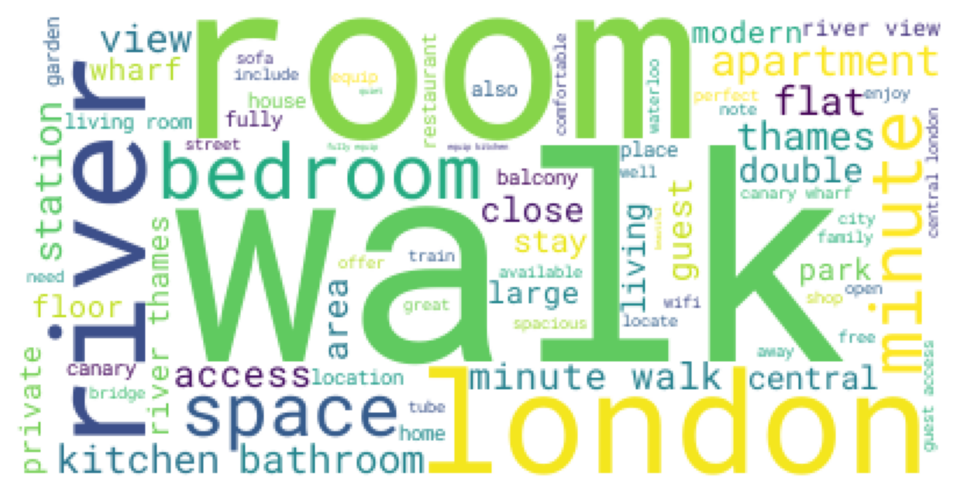

In [52]:
f,ax = plt.subplots(1,1,figsize=(8, 8))
plt.gcf().set_dpi(150)
Cloud = WordCloud(
    background_color="white", 
    max_words=75,
    font_path=fp
).generate_from_frequencies(fcvdf.sum())
ax.imshow(Cloud) 
ax.axis("off");
#plt.savefig("Wordcloud 1.png")

### 6.2 For TF/IDF Weighting

> **Difficulty level: Low, but you’ll need to be patient!**

In [53]:
tfidf.sum().sort_values(ascending=False)

walk                     23.037285
room                     19.135852
london                   18.744519
minute                   18.650909
apartment                18.082855
                           ...    
station apartment one     0.401426
station also close        0.401426
apartment one benefit     0.401426
apartment one             0.401426
also close station        0.401426
Length: 1911, dtype: float64

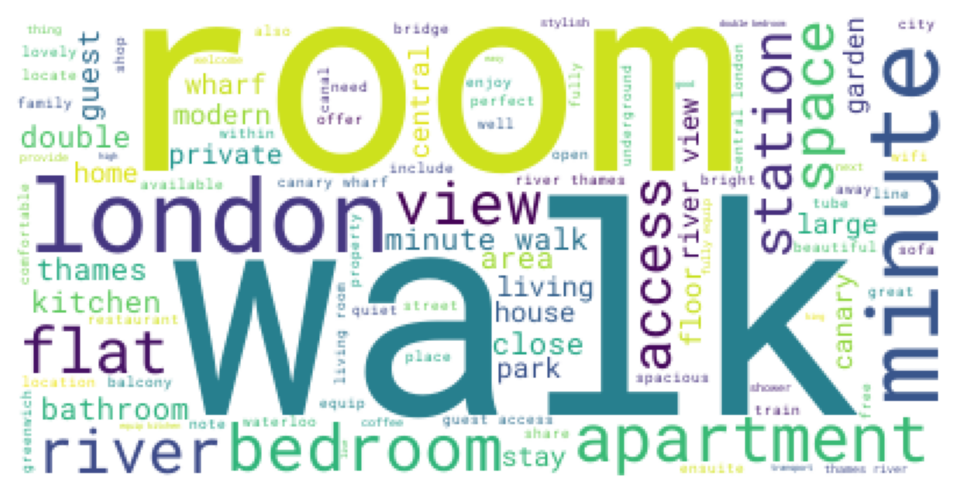

In [54]:
f,ax = plt.subplots(1,1,figsize=(8, 8))
plt.gcf().set_dpi(150)
Cloud = WordCloud(
    background_color="white", 
    max_words=100,
    font_path=fp
).generate_from_frequencies(tfidf.sum())
ax.imshow(Cloud) 
ax.axis("off");
#plt.savefig("Wordcloud 2.png")

#### 6.2.1 Questions

-   What does the `sum` represent for the count vectoriser?
-   What does the `sum` represent for the TF/IDF vectoriser?

## 7. Latent Dirchlet Allocation

> **Tip**
>
> I would give this a *low* priority. It’s a commonly-used method, but
> on small data sets it really isn’t much use and I’ve found its answers
> to be… unclear… even on large data sets.

Adapted from [this
post](https://stackabuse.com/python-for-nlp-topic-modeling/) on doing
LDA using sklearn. Most other examples use the `gensim` library.

In [55]:
# Notice change to ngram range 
# (try 1,1 and 1,2 for other options)
vectorizer = CountVectorizer(ngram_range=(1,2))

### 7.1 Calculate Topics

In [56]:
vectorizer.fit(corpus) 
tcorpus = vectorizer.transform(corpus) # tcorpus for transformed corpus

LDA = LatentDirichletAllocation(n_components=3, random_state=42) # Might want to experiment with n_components too
LDA.fit(tcorpus)

LatentDirichletAllocation(n_components=3, random_state=42) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.   LatentDirichletAllocation ? Documentation for LatentDirichletAllocation i Fitted LatentDirichletAllocation(n_components=3, random_state=42)

In [57]:
first_topic = LDA.components_[0]
top_words = first_topic.argsort()[-25:]

for i in top_words:
    print(vectorizer.get_feature_names_out()[i])

river thames
modern
area
wharf
flat
access
bathroom
guest
house
minute
private
kitchen
large
thames
living
view
station
floor
bedroom
apartment
walk
london
river
room
space

In [58]:
for i,topic in enumerate(LDA.components_):
    as_markdown(f'Top 10 words for topic #{i}', ', '.join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-25:]]))

### 7.2 Maximum Likelihood Topic

In [59]:
topic_values = LDA.transform(tcorpus)
topic_values.shape

(408, 3)

In [60]:
pd.options.display.max_colwidth=20
srcdf['Topic'] = topic_values.argmax(axis=1)
srcdf.head()

In [61]:
pd.options.display.max_colwidth=75
srcdf[srcdf.Topic==1].description_norm.head(10)

19      house garden close thames river . walk  private road river nearby .  di...
928     brand riverside apartment greenwich peninsula . perfect explore london ...
1424    mint walk thames river  mint tower bridge  mint greenwich bus mint walk...
1644    bright  spacious chill bedroom cosy apartment level friendly quiet bloc...
3887    fabulous bathshower flat modern development east putney  london literal...
3966    large double room river view available large spacious townhouse hampton...
4664    private quiet bright  large double room ensuite bathroom . location stu...
4890    bright  airy bedroom  ground floor apartment quiet street . modernly fu...
5815    perfect claphambattersea modern decor . brand kitchenbathroom minute wa...
6699    room front house overlook balcony  road river . bright sunny house view...
Name: description_norm, dtype: object

In [62]:
vectorizer = CountVectorizer(ngram_range=(1,1), stop_words='english', analyzer='word', max_df=0.7, min_df=0.05)
topic_corpus = vectorizer.fit_transform(srcdf[srcdf.Topic==1].description.values) # tcorpus for transformed corpus

In [63]:
topicdf = pd.DataFrame(data=topic_corpus.toarray(),
                        columns=vectorizer.get_feature_names_out())

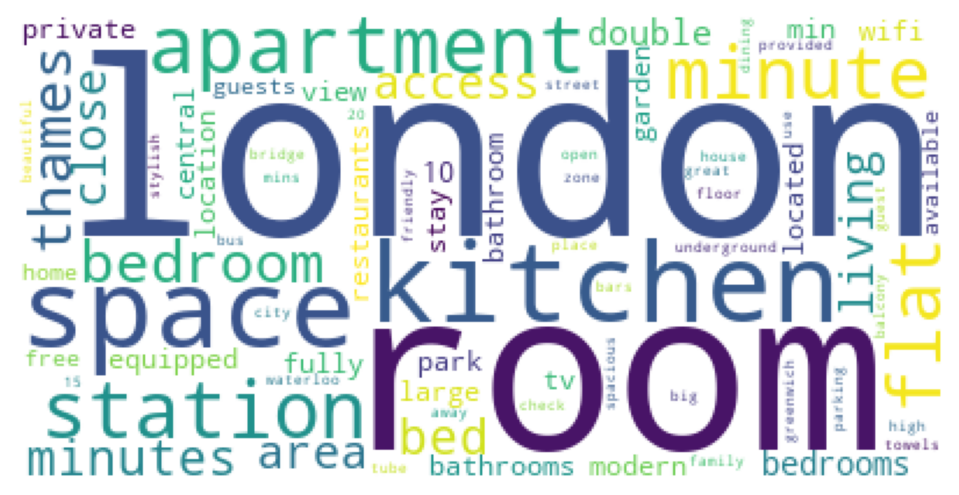

In [64]:
f,ax = plt.subplots(1,1,figsize=(8,8))
plt.gcf().set_dpi(150)
Cloud = WordCloud(
            background_color="white", 
            max_words=75).generate_from_frequencies(topicdf.sum())
ax.imshow(Cloud) 
ax.axis("off");
# plt.savefig('Wordcloud 3.png')

## 8. Word2Vec

> **Tip**
>
> This algorithm works almost like magic. You should play with the
> configuration parameters and see how it changes your results.

### 8.1 Configure

In [65]:
from gensim.models.word2vec import Word2Vec

In [66]:
dims = 100
print(f"You've chosen {dims} dimensions.")

window = 4
print(f"You've chosen a window of size {window}.")

min_v_freq  = 0.01 # Don't keep words appearing less than 1% frequency
min_v_count = math.ceil(min_v_freq * srcdf.shape[0])
print(f"With a minimum frequency of {min_v_freq} and {srcdf.shape[0]:,} documents, minimum vocab frequency is {min_v_count:,}.")

You've chosen 100 dimensions.
You've chosen a window of size 4.
With a minimum frequency of 0.01 and 408 documents, minimum vocab frequency is 5.

### 8.2 Train

In [67]:
%%time 

corpus      = srcdf.description_norm.fillna(' ').values
#corpus_sent = [nltk.sent_tokenize(text) for text in corpus] # <-- with more formal writing this would work well
corpus_sent = [d.replace('.',' ').split(' ') for d in corpus] # <-- deals better with many short sentences though context may end up... weird
model       = Word2Vec(sentences=corpus_sent, vector_size=dims, window=window, epochs=200, 
                 min_count=min_v_count, seed=42, workers=1)

#model.save(f"word2vec-d{dims}-w{window}.model") # <-- You can then Word2Vec.load(...) which is useful with large corpora

CPU times: user 4.02 s, sys: 87.3 ms, total: 4.1 s
Wall time: 4.09 s

### 8.3 Explore Similarities

This next bit of code only runs if you have calculated the frequencies
above in the [Frequencies and Ngrams](#frequencies-and-ngrams) section.

In [68]:
pd.set_option('display.max_colwidth',150)

df = fcounts[1] # <-- copy out only the unigrams as we haven't trained anything else

n     = 14 # number of words
topn  = 7  # number of most similar words

selected_words = df[df['Ngram Size 1'] > 5].reset_index().level_0.sample(n, random_state=42).tolist()

words = []
v1    = []
v2    = []
v3    = []
sims  = []

for w in selected_words:
    try: 
        vector = model.wv[w]  # get numpy vector of a word
        #print(f"Word vector for '{w}' starts: {vector[:5]}...")
    
        sim = model.wv.most_similar(w, topn=topn)
        #print(f"Similar words to '{w}' include: {sim}.")
    
        words.append(w)
        v1.append(vector[0])
        v2.append(vector[1])
        v3.append(vector[2])
        sims.append(", ".join([x[0] for x in sim]))
    except KeyError:
        print(f"Didn't find {w} in model. Can happen with low-frequency terms.")
    
vecs = pd.DataFrame({
    'Term':words,
    'V1':v1, 
    'V2':v2, 
    'V3':v3,
    f'Top {topn} Similar':sims
})

vecs

``` python
#print(model.wv.index_to_key) # <-- the full vocabulary that has been trained
```

### 8.4 Apply

We’re going to make *use* of this further next week…

#### 8.4.1 Questions

-   What happens when *dims* is very small (e.g. 25) or very large
    (e.g. 300)?
-   What happens when *window* is very small (e.g. 2) or very large
    (e.g. 8)?

## 9. Processing the Full File

> **Caution**
>
> This code can take *some time* (**\> 5 minutes on a M2 Mac**) to run,
> so **don’t run this** until you’ve understood what we did before!

You will get a warning about `"." looks like a filename, not markup` —
this looks a little scary, but is basically suggesting that we have a
description that consists only of a ‘.’ or that looks like some kind of
URL (which the parser thinks means you’re trying to pass it something to
download).

``` python
%%time 
# This can take up to 8 minutes on a M2 Mac
gdf['description_norm'] = ''
gdf['description_norm'] = gdf.description.apply(normalise_document, remove_digits=True, special_char_removal=True)
```

``` python
gdf.to_parquet(os.path.join('data','geo',f'{fn.replace(".","-with-nlp.")}'))
```

> **Tip**
>
> Saving an intermediate file at this point is useful because you’ve
> done quite a bit of *expensive* computation. You *could*
> restart-and-run-all and then go out for the day, but probably easier
> to just save this output and then, if you need to restart your
> analysis at some point in the future, just remember to deserialise
> amenities back into a list format.

### 9.1 Applications

The above is *still* only the results for the one of the subsets of
apartments *alone*. At this point, you would probably want to think
about how your results might change if you changed any of the following:

1.  Using one of the other data sets that we created, or even the entire
    data set!
2.  Applying the CountVectorizer or TfidfVectorizer *before* selecting
    out any of our ‘sub’ data sets.
3.  Using the visualisation of information to improve our regex
    selection process.
4.  Reducing, increasing, or constraining (i.e. `ngrams=(2,2)`) the size
    of the ngrams while bearing in mind the impact on processing time
    and interpretability.
5.  Filtering by type of listing or host instead of keywords found in
    the description (for instance, what if you applied TF/IDF to the
    entire data set and then selected out ‘Whole Properties’ before
    splitting into those advertised by hosts with only one listing
    vs. those with multiple listings?).
6.  Linking this back to the geography.

Over the next few weeks we’ll also consider alternative means of
visualising the data!

### 9.2 Resources

There is a lot more information out there, including a [whole
book](https://www.nltk.org/book/) and your standard [O’Reilly
text](http://www.datascienceassn.org/sites/default/files/Natural%20Language%20Processing%20with%20Python.pdf).

And some more useful links:

-   [Pandas String Contains
    Method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.contains.html)
-   [Using Regular Expressions with
    Pandas](https://kanoki.org/2019/11/12/how-to-use-regex-in-pandas/)
-   [Summarising Chapters from Frankenstein using
    TF/IDF](https://towardsdatascience.com/using-tf-idf-to-form-descriptive-chapter-summaries-via-keyword-extraction-4e6fd857d190)